In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
# CSV 파일 불러오기
df = pd.read_csv("/content/sample_data/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# 컬렴명 확인
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
print("결측치 확인:\n", df.isnull().sum())

결측치 확인:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [5]:
# 결측치 제거
df = df.dropna()
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [7]:
# 1. 데이터 전처리 (X: 특성, y: 타겟)
X = df.drop(['Outcome', 'BMI'], axis=1).values
y = df["BMI"].values
print(X)
print(y)

[[  6.    148.     72.    ...   0.      0.627  50.   ]
 [  1.     85.     66.    ...   0.      0.351  31.   ]
 [  8.    183.     64.    ...   0.      0.672  32.   ]
 ...
 [  5.    121.     72.    ... 112.      0.245  30.   ]
 [  1.    126.     60.    ...   0.      0.349  47.   ]
 [  1.     93.     70.    ...   0.      0.315  23.   ]]
[33.6 26.6 23.3 28.1 43.1 25.6 31.  35.3 30.5  0.  37.6 38.  27.1 30.1
 25.8 30.  45.8 29.6 43.3 34.6 39.3 35.4 39.8 29.  36.6 31.1 39.4 23.2
 22.2 34.1 36.  31.6 24.8 19.9 27.6 24.  33.2 32.9 38.2 37.1 34.  40.2
 22.7 45.4 27.4 42.  29.7 28.  39.1  0.  19.4 24.2 24.4 33.7 34.7 23.
 37.7 46.8 40.5 41.5  0.  32.9 25.  25.4 32.8 29.  32.5 42.7 19.6 28.9
 32.9 28.6 43.4 35.1 32.  24.7 32.6 37.7 43.2 25.  22.4  0.  29.3 24.6
 48.8 32.4 36.6 38.5 37.1 26.5 19.1 32.  46.7 23.8 24.7 33.9 31.6 20.4
 28.7 49.7 39.  26.1 22.5 26.6 39.6 28.7 22.4 29.5 34.3 37.4 33.3 34.
 31.2 34.  30.5 31.2 34.  33.7 28.2 23.2 53.2 34.2 33.6 26.8 33.3 55.
 42.9 33.3 34.5 27.9 29.7 33

In [8]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)

[[ 0.63994726  0.84832379  0.14964075 ... -0.69289057  0.46849198
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.69289057 -0.36506078
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 ... -0.69289057  0.60439732
  -0.10558415]
 ...
 [ 0.3429808   0.00330087  0.14964075 ...  0.27959377 -0.68519336
  -0.27575966]
 [-0.84488505  0.1597866  -0.47073225 ... -0.69289057 -0.37110101
   1.17073215]
 [-0.84488505 -0.8730192   0.04624525 ... -0.69289057 -0.47378505
  -0.87137393]]


In [21]:
# 3. 데이터 분할 (훈련 80%, 테스트 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("data SHAPE :")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

data SHAPE :
(614, 7) (614,)
(154, 7) (154,)


In [22]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 7]),
 torch.Size([154, 7]),
 torch.Size([614]),
 torch.Size([154]))

In [53]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1) # 1 classes in the dataset

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

손실함수 및 최적화 기법 정의


1.   nn.CrossEntropyLoss() :
*   float(prediction) -> long(target)
2.   nn.BCELoss() :
*   float(prediction) -> float(target)
3.   nn.BCEWithLogitsLoss():
*   float(prediction) -> float(target)
4.   nn.MSELoss() :
*   float(prediction) -> float(target)

In [54]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

모델 학습

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_losses = []
test_rmses = []
test_maes = []
test_r2s = []

num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 평균 훈련 손실 저장
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # 테스트셋에서 평가
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            preds.extend(outputs.squeeze().cpu().tolist())
            targets.extend(labels.squeeze().cpu().tolist())

    # 회귀 지표 계산
    mse = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)

    test_rmses.append(rmse)
    test_maes.append(mae)
    test_r2s.append(r2)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 1/25
Train Loss: 1068.1459 | RMSE: 32.5740 | MAE: 31.5148 | R²: -13.9267
Epoch 2/25
Train Loss: 1021.1948 | RMSE: 31.3072 | MAE: 30.2982 | R²: -12.7882
Epoch 3/25
Train Loss: 910.9770 | RMSE: 29.0118 | MAE: 28.0641 | R²: -10.8405
Epoch 4/25
Train Loss: 758.8296 | RMSE: 25.3989 | MAE: 24.4443 | R²: -8.0750
Epoch 5/25
Train Loss: 543.3514 | RMSE: 20.5520 | MAE: 19.2647 | R²: -4.9419


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, tar

Epoch 6/25
Train Loss: 323.1380 | RMSE: 15.4804 | MAE: 13.3224 | R²: -2.3712
Epoch 7/25
Train Loss: 176.6402 | RMSE: 12.1905 | MAE: 9.3546 | R²: -1.0906
Epoch 8/25
Train Loss: 120.3199 | RMSE: 11.1028 | MAE: 7.9939 | R²: -0.7341
Epoch 9/25
Train Loss: 108.3051 | RMSE: 10.7193 | MAE: 7.6208 | R²: -0.6164
Epoch 10/25
Train Loss: 100.8972 | RMSE: 10.3995 | MAE: 7.4138 | R²: -0.5214
Epoch 11/25
Train Loss: 100.2016 | RMSE: 10.2490 | MAE: 7.3450 | R²: -0.4777


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, tar

Epoch 12/25
Train Loss: 95.5055 | RMSE: 10.1252 | MAE: 7.2733 | R²: -0.4422
Epoch 13/25
Train Loss: 96.0988 | RMSE: 10.0910 | MAE: 7.2759 | R²: -0.4325
Epoch 14/25
Train Loss: 91.2559 | RMSE: 9.9994 | MAE: 7.1694 | R²: -0.4066
Epoch 15/25
Train Loss: 88.9642 | RMSE: 9.8769 | MAE: 7.0870 | R²: -0.3723
Epoch 16/25
Train Loss: 87.3997 | RMSE: 9.8350 | MAE: 7.0692 | R²: -0.3607
Epoch 17/25
Train Loss: 92.3896 | RMSE: 9.8321 | MAE: 7.0346 | R²: -0.3599


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 18/25
Train Loss: 85.4537 | RMSE: 9.8197 | MAE: 6.9796 | R²: -0.3565
Epoch 19/25
Train Loss: 84.5896 | RMSE: 9.7533 | MAE: 6.9270 | R²: -0.3382
Epoch 20/25
Train Loss: 85.5372 | RMSE: 9.5997 | MAE: 6.8418 | R²: -0.2964
Epoch 21/25
Train Loss: 80.6011 | RMSE: 9.6076 | MAE: 6.8082 | R²: -0.2985
Epoch 22/25
Train Loss: 78.5476 | RMSE: 9.5507 | MAE: 6.7789 | R²: -0.2832
Epoch 23/25
Train Loss: 81.5185 | RMSE: 9.5095 | MAE: 6.7112 | R²: -0.2721
Epoch 24/25
Train Loss: 77.3528 | RMSE: 9.3503 | MAE: 6.6484 | R²: -0.2299
Epoch 25/25
Train Loss: 85.8575 | RMSE: 9.3649 | MAE: 6.5934 | R²: -0.2337


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, tar

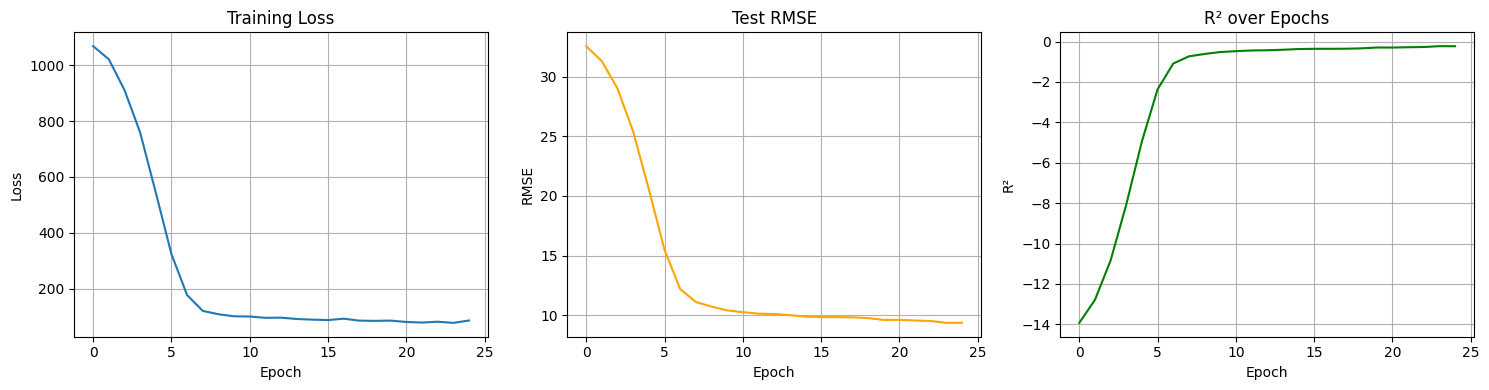

In [56]:
plt.figure(figsize=(15, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# RMSE
plt.subplot(1, 3, 2)
plt.plot(test_rmses, label='RMSE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.grid(True)

# R²
plt.subplot(1, 3, 3)
plt.plot(test_r2s, label='R² Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('R² over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()